# Center of Mass estimator: tutorial

If the center_of_mass package is not installed, run the following lines:
```
import sys
sys.path.insert(0, '../src')
```

In [2]:
import center_of_mass

In [3]:
import numpy, pickle

The example data file is loaded

In [4]:
input_file     = '..\examples\example_data.pkl'
pickle_file    = open(input_file,'rb')
data           = pickle.load(pickle_file)
pickle_file.close()

sex                 = data['sex']                # 'female' or 'male'
Labels              = data['Labels']             # list of marker labels
Kinematic_frequency = data['Position_frequency'] # in Hertz
Position            = data['Position']           # dictionary with, for each marker, the position in meters (numpy.ndarray of shape (3,duration*Position_frequency)
Force_frequency     = data['Force_frequency']    # in Hertz
GroundReactionForce = data['GroundReactionForce']# in Newtons (numpy.ndarray of shape (3,duration*Force_frequency)

The center of mass is calculated (in this example we use the method of Dumas et al. 2007).

In [5]:
kinematics    = center_of_mass.Kinematics(Position, Labels, sex)
Kinematic_com = kinematics.calculate_CoM()

The person's mass is determined as the median vertical ground reaction force during the initial 1.5 seconds of quiet standing

In [6]:
mass = numpy.median(GroundReactionForce[2,:int(1.5*Force_frequency)])/9.81

The position and velocity estimates are calculated

In [7]:
args = (GroundReactionForce, Force_frequency, Kinematic_com, Kinematic_frequency, mass)
Pos_estimate, Vel_estimate, Frequency = center_of_mass.estimator.optimal_combination(*args)

## Option 1: Frame of reference
The frame of reference for the Ground reaction force and the kinematics should be the same. By default, the code assumes that the first two dimensions (x,y) are horizontal, and the third dimension (z) is vertical, oriented upwards, as in (1). 
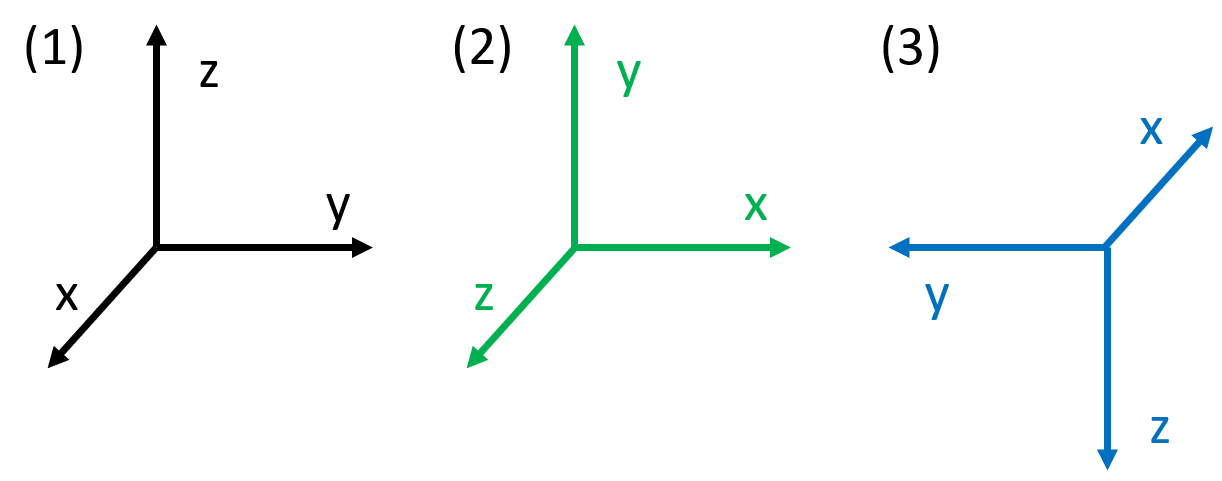

If this is not the case, then the direction of gravity must be specified as gravity_direction: for example [0,-1,0] in (2), or [0,0,1] in (3). The code then calculates the CoM acceleration by subtracting the person's weight from the Ground reaction force.

In [9]:
# Example in (2): Rotation of the Ground reaction force and kinematic CoM
rotated_GroundReactionForce = numpy.zeros((numpy.shape(GroundReactionForce)))
rotated_Kinematic_com       = numpy.zeros((numpy.shape(Kinematic_com)))
rotation_indices            = [1,2,0]

for i, index in enumerate(rotation_indices):
    rotated_GroundReactionForce[i] = GroundReactionForce[index]
    rotated_Kinematic_com[i]       = Kinematic_com [index]

# The row corresponding to the vertical direction is specified when calculating the estimate of CoM position and velocity
gravity_direction = [0,-1,0]
rotated_args      = (rotated_GroundReactionForce, Force_frequency, rotated_Kinematic_com, Kinematic_frequency, mass)
Pos_estimate, Vel_estimate, Frequency = center_of_mass.estimator.optimal_combination(*rotated_args,gravity_direction = gravity_direction)

In [10]:
# Example in (3): Inversion of the Ground reaction force and kinematic CoM
inverted_GroundReactionForce = - GroundReactionForce
inverted_Kinematic_com       = - Kinematic_com
# The direction of the vertical dimension is specified to -1 (downwards)
gravity_direction = [0,0,1]
inverted_args = (inverted_GroundReactionForce, Force_frequency, inverted_Kinematic_com, Kinematic_frequency, mass)
Pos_estimate, Vel_estimate, Frequency = center_of_mass.estimator.optimal_combination(*inverted_args,gravity_direction = gravity_direction)

## Option 2: Sub-sampling frequency
In the example data, the kinematics are sampled at 200 Hz and the force at 1000 Hz. The code automatically selects a sub-sampling frequency of 200 Hz for the two signals (corresponding to the greatest common divisor). However, the user can specify any common divisor as the sub-sampling frequency through the optional argument "sub_frequency".

In [11]:
sub_frequency = 100 # in Hertz
Pos_estimate, Vel_estimate, Frequency = center_of_mass.estimator.optimal_combination(*args,sub_frequency = sub_frequency)

## Option 3: Initial conditions
By default, the initial position and speed for the estimator are obtained by a least-squares fit of the first and last ten samples of the kinematic Center of Mass. This number of samples can be modified by specifying the optional argument "initial_samples".

In [12]:
initial_samples = 20
Pos_estimate, Vel_estimate, Frequency = center_of_mass.estimator.optimal_combination(*args,initial_samples = initial_samples)

Alternately, the user may wish to use a custom method to determine the initial conditions. In this case, they can specify the desired initial conditions for both the forwards estimator using the optional argument "Initial_conditions", and for the backwards estimator using the optional argument "Final_conditions".

In the example data, the subject is initially static. We can specify an initial velocity of zero.

In [13]:
initial_position = Kinematic_com[:,0]
initial_velocity = numpy.zeros((3))
Initial_conditions = numpy.array([initial_position,initial_velocity]).T
Pos_estimate, Vel_estimate, Frequency = center_of_mass.estimator.optimal_combination(*args,Initial_conditions = Initial_conditions)

In [14]:
Pos_estimate, Vel_estimate, Frequency = center_of_mass.estimator.optimal_combination(*args,Initial_conditions = Initial_conditions)

## Option 4: Measurement noise

Different values of the position and measurement noise can be specified. These are used for the calculation of the estimator gains

In [15]:
Position_std = 0.0035 # standard deviation of the error in CoM position obtained from the kinematics alone (in m)
Force_std    = 2      # standard deviation of the error in Ground reaction force (in N)

In [16]:
Pos_estimate, Vel_estimate, Frequency = center_of_mass.estimator.optimal_combination(*args,Position_std = Position_std, Force_std = Force_std)

The measurement noise can be specified in each direction for either position, force or both:

In [18]:
Position_std = 0.0035 # standard deviation of the error in CoM position obtained from the kinematics alone (in m)
Force_std    = numpy.array([2,2,4]) # standard deviation of the error in Ground reaction force in each direction (in N)
Pos_estimate, Vel_estimate, Frequency = center_of_mass.estimator.optimal_combination(*args,Position_std = Position_std, Force_std = Force_std)

In [19]:
Position_std = numpy.array([0.002,0.002,0.004]) # standard deviation of the error in CoM position in each direction (in m)
Force_std    = 2                                # standard deviation of the error in Ground reaction force(in N)
Pos_estimate, Vel_estimate, Frequency = center_of_mass.estimator.optimal_combination(*args,Position_std = Position_std, Force_std = Force_std)

In [20]:
Position_std = numpy.array([0.002,0.002,0.004]) # standard deviation of the error in CoM position in each direction (in m)
Force_std    = numpy.array([2,2,4])             # standard deviation of the error in Ground reaction force in each direction (in N)
Pos_estimate, Vel_estimate, Frequency = center_of_mass.estimator.optimal_combination(*args,Position_std = Position_std, Force_std = Force_std)